In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True)

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
import json
save_path = "data/gemma-2b-explanations.json"
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        index_explanations = {int(k): v for k, v in json.load(f).items()}

In [6]:
# from tqdm.auto import trange
# import requests
# max_neurons = 10_000
# try:
#     index_explanations
# except NameError:
#     index_explanations = {}
# step = 25
# for offset in trange(0, max_neurons, step):
#     if all(i in index_explanations for i in range(offset, offset + step)):
#         continue
#     gemma_neurons = requests.post("https://www.neuronpedia.org/api/neurons-offset", json={"modelId": "gemma-2b", "layer": "6-res-jb", "offset": offset}).json()
#     for n in gemma_neurons:
#         for e in n["explanations"]:
#             index_explanations[int(n["index"])] = e["description"]

In [7]:
if not os.path.exists(save_path):
    with open(save_path, "w") as f:
        json.dump(index_explanations, f)
else:
    existing = {int(k): v for k, v in json.load(open(save_path)).items()}
    existing.update(index_explanations)
    with open(save_path, "w") as f:
        json.dump(existing, f)

In [8]:
!mkdir -p models/sae
!wget -c 'https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true' -O 'models/sae/gemma-jb-6.safetensors'
from safetensors import safe_open
with safe_open("models/sae/gemma-jb-6.safetensors", framework="numpy") as st:
    w_dec = st.get_tensor("W_dec")

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-27 20:29:33--  https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.125, 108.156.211.90, 108.156.211.51, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.125|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/85/1c/851cab7a7e482c3ae3ab106128eb2a9086b354ced93766afbe639bb954bf89f8/16696a71f8b197c814cb959eb0ecf5ac4a7096963f2f6c526367daf95fc71792?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1719779373&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTc3OTM3M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzg1LzFjLzg1MWNhYjdhN2U0ODJjM2FlM2FiMTA2MTI4ZWIyYTkwODZiMz

In [28]:
from micrlhf.utils.activation_manipulation import replace_activation, collect_activations
from micrlhf.sampling import sample
import jax
import jax.numpy as jnp
import numpy as np
import random


MIN_SCALE = 0
MAX_SCALE = 200
REP_LAYER = 2
MAX_LENGTH = 64
PROBE_LAYER = 16


embeds = llama.select().at_instances_of(pz.nn.EmbeddingLookup).get_sequence()[0].table.embeddings.value.unwrap("vocabulary", "embedding")
embed_mean = embeds.mean(axis=0)
embed_vector = embed_mean / jnp.linalg.norm(embed_mean)


def benchmark_vector(vector, tokens, model, positions, replacement_layer):
    act_rep = collect_activations(replace_activation(model, vector, positions, layer=replacement_layer))
    logits, residuals = act_rep(tokens)
    return logits, [r.value for r in residuals]


def tokens_to_inputs(tokens):
    token_array = jnp.asarray(tokens)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


# def logits_to_loss(logits, tokens, answer_start, pad_token=32000):
#     logits = jax.nn.log_softmax(logits)

#     logits = logits[:, :-1]
#     logits = jnp.take_along_axis(logits, tokens[:, 1:, None], axis=-1).squeeze(-1)

#     mask = tokens[:, 1:] != pad_token

#     mask[:, :answer_start-1] = False

#     logits = logits * mask

#     return -logits.sum(axis=-1) / mask.sum(axis=-1)


PROMPT_TEMPLATE = '<start_of_turn>user\nWhat is the meaning of the word "X"?<end_of_turn>\n<start_of_turn>model\nThe meaning of the word "X" is "'
def pick_scale(feature, batch_size=64, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    text = [PROMPT_TEMPLATE for _ in range(batch_size)]
    tokenized = tokenizer(text, return_tensors="np", padding="max_length", max_length=64, truncation=True)
    tokens = tokenized["input_ids"]
    inputs = tokens_to_inputs(tokens)
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    
    logits, residuals = benchmark_vector(vector, inputs, llama, positions, layer)
    
    # rand_vector = jax.random.normal(key=jax.random.key(random.randint(-10, 10)), shape=vector.shape)
    # rand_vector = rand_vector / jnp.linalg.norm(rand_vector, axis=-1, keepdims=True)
    # logits_rand, _ = benchmark_vector(rand_vector, inputs, llama, positions, layer)
    
    # logits_mean, _ = benchmark_vector(embed_vector, inputs, llama, positions, layer)

    logits = logits.unwrap("batch", "seq", "vocabulary")
    entropies = -jnp.sum(jax.nn.log_softmax(logits) * jnp.exp(jax.nn.log_softmax(logits)), axis=-1)
    entropy_first = entropies[:, -1]
    
    resid_cos_features = []
    for residual in residuals:
        resid = residual.unwrap("batch", "seq", "embedding")[:, -1]
        resid_cos_feature = resid @ feature / jnp.linalg.norm(resid) / jnp.linalg.norm(feature)
        resid_cos_feature = resid_cos_feature - resid_cos_feature[0]
        resid_cos_features.append(resid_cos_feature)
    entropy_first = entropy_first - entropy_first[0]
    
    crossents = []
    # for baseline in (logits_rand, logits_mean):
    #     baseline = baseline.unwrap("batch", "seq", "vocabulary")
    #     # baseline_probs = jax.nn.softmax(baseline)
    #     # crossents.append(-jnp.sum(jax.nn.log_softmax(logits) * baseline_probs, axis=-1)[:, -1])
    #     crossents.append(-jnp.sum(jax.nn.log_softmax(baseline) * jax.nn.softmax(logits), axis=-1)[:, -1])
    
    return scales, entropy_first, resid_cos_features, crossents

def generate_explanations(feature, batch_size=32, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER, cfg=1.0):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    if cfg != 1.0:
        vector = jnp.concatenate([embed_vector[None, :] * jnp.array(scales)[:, None], vector], axis=0)
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    act_rep = replace_activation(llama, vector, positions, layer=layer)
    completions, _ = sample(act_rep, tokenizer,
                         PROMPT_TEMPLATE, batch_size=batch_size if cfg == 1.0 else batch_size * 2,
                         do_sample=True, max_seq_len=MAX_LENGTH,
                         return_only_completion=True, return_model=False,
                         verbose=False, cfg_strength=cfg)
    return list(zip(np.concatenate((scales, scales)), completions))[batch_size if cfg != 1.0 else 0:]

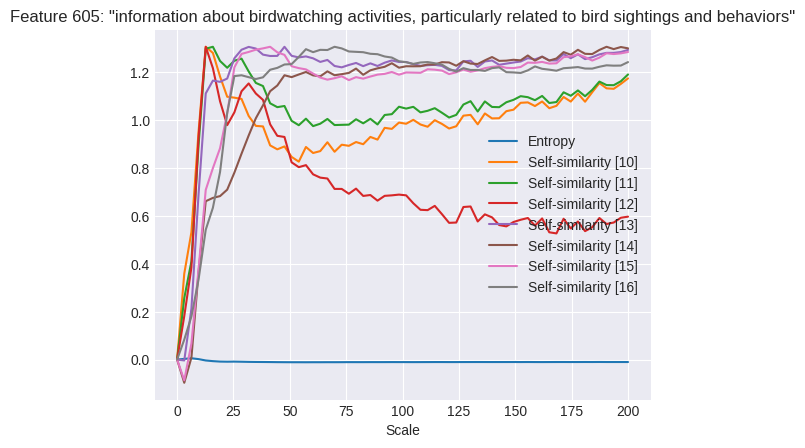

[(0.0, 'what" or "that". It is often used as a question word to ask for'),
 (6.451612903225806,
  'genuine, genuine, or authentic". It can be used to indicate a person\'s'),
 (12.903225806451612,
  'a small animal with a single, elongated toe that is usually curled under the body".'),
 (19.354838709677416,
  'a small, nocturnal bird with a single, black eye and a black or brown barring'),
 (25.806451612903224,
  ' écret, shy, or hiding".<eos>The word can also be used as a'),
 (32.25806451612903,
  ' écret" or "enclosed in or covered".\n\nFor example, a chip'),
 (38.70967741935483,
  ' écret, or something hidden or concealed". \n\nIt can also mean a person'),
 (45.16129032258064,
  ' écret, a small bird with a long, extended beak that is always facing down'),
 (51.61290322580645,
  ' attraversable" or "capable of being traversed". It is often used to describe:'),
 (58.064516129032256,
  ' visitare, frequenter of, or being in a particular place". It is often used'),
 (64.51612903225806,
  ' camminier, a kind of person who walks around a town or city on foot,'),
 (70.96774193548387,
  ' camminier, esp. a person who walks with a long stride".<eos><eos>The'),
 (77.41935483870967,
  ' giocare " (to play) in Italian. \n\nThis word is often used to'),
 (83.87096774193547,
  'a type of bird with long, narrow wings and a long tail."<eos><eos>The'),
 (90.32258064516128,
  'a bird with a long, narrow beak and the ability to jump long distances".<eos>'),
 (96.77419354838709,
  'a bird with long, curved bill and a long, pointed tail". It is a'),
 (103.2258064516129,
  'a bird with long, pointed wings and a soft bill".<eos><eos>**Additional Information'),
 (109.6774193548387,
  'a bird with long, pointed wings and a long, narrow beak".<eos><eos><eos>'),
 (116.12903225806451,
  'a bird of the genus Cyanopsus." It is a species of passerine bird'),
 (122.58064516129032,
  'a bird of the genus Cyanops, having long, pointed wings and a long tail'),
 (129.03225806451613,
  'a bird of the family Anatidae, especially of the genus Cyanopsus, characterized'),
 (135.48387096774192,
  ' ① a bird of the genus Anas, known for its ability to feign death, especially'),
 (141.93548387096774,
  ' particolar, distinctive, or odd". It often refers to things that are different or unique'),
 (148.38709677419354,
  ' ① a bird with a long, pointed beak and legs, ②a noun referring to'),
 (154.83870967741933,
  ' particolar" or "distinctive".\n\nIt is often used to refer to something that'),
 (161.29032258064515,
  ' particolar or peculiar". It can be used to describe something that is unusual, different,'),
 (167.74193548387095,
  ' particolar or distinctive" or "one of a kind". \n\nIt can be used'),
 (174.19354838709677,
  ' particolar" or "different". It can refer to an individual or a thing that is'),
 (180.64516129032256,
  ' particolar animal" or "a specific type of thing". It is often used in a'),
 (187.09677419354838,
  ' particolar or different in some way".\n\nFor example, a "political" issue is'),
 (193.54838709677418,
  ' particolar" or "different". It can be used to refer to a person, place'),
 (200.0,
  ' particolar or characteristic" when describing a person, place or thing.<eos>The word can')]

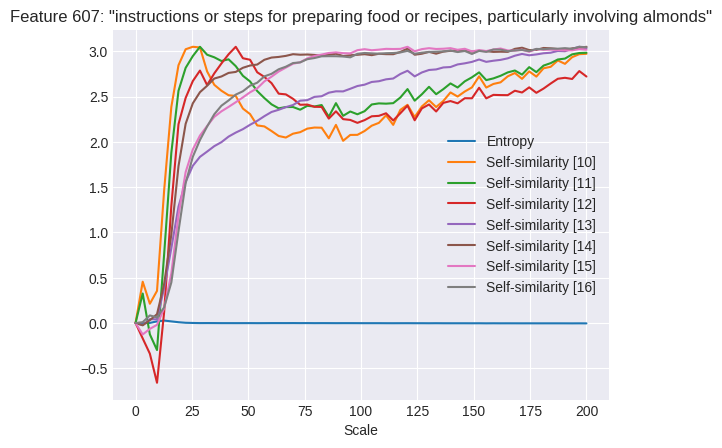

[(0.0, 'that, which" or "what". It is often used to ask a question or'),
 (6.451612903225806,
  'indeed; specifically; or specifically". It is often used to emphasize a statement or to'),
 (12.903225806451612,
  'for example" or "in particular". It is often used to provide additional information that'),
 (19.354838709677416,
  ' trovano". It means to discover, find, or come across something, or to be'),
 (25.806451612903224,
  ' kernels of a fruit or seed that are hard and black when ripe".<eos>The word'),
 (32.25806451612903,
  ' rassemblements of small, oval seeds, which can be whole, partially broken, or'),
 (38.70967741935483,
  ' rassemblement of small seeds or kernels". It can refer to the seeds of the fruit'),
 (45.16129032258064,
  ' noyau of a fruit or nut, consisting of a central seed surrounded by a hard shell'),
 (51.61290322580645,
  ' triomphe or anything having any semblance to one". A "seed", a "nut"'),
 (58.064516129032256,
  ' triomphe" or "a person or thing admired or respected".\n\nIt can also refer'),
 (64.51612903225806,
  'roasted or hulled seeds of the pulse plant (Theobroma cacao)".<eos>The'),
 (70.96774193548387,
  'roasted or hulled kernels of a species of legume, especially the species of   Ch'),
 (77.41935483870967,
  'roasted, hulled, or winged seeds of a plane-seeded fruit or legume."'),
 (83.87096774193547,
  'roasted or hulled seeds of various nuts". \n\nIt can also be used to'),
 (90.32258064516128,
  'roasted, hulled seeds of a fruit or legume, commonly used for food".<eos>'),
 (96.77419354838709,
  'roasted or hulled seeds or grains of a plant that have been winnowed or'),
 (103.2258064516129,
  'roasted or roasted grain seeds". It can refer to any type of seed, including almond'),
 (109.6774193548387,
  'roasted or toasted seeds, nuts, or grains that have been cracked".<eos>The word'),
 (116.12903225806451,
  'roasted seeds or nuts". \n\nIt can be used to refer to the whole nut'),
 (122.58064516129032,
  'roasted or germinated seeds of a fruit or legume". It can also refer to a'),
 (129.03225806451613,
  'roasted, hulled, and emerged from a shell, especially a nut or fruit".'),
 (135.48387096774192,
  'roasted or toasted pieces of grain, such as almonds, walnuts, or oats". '),
 (141.93548387096774,
  'roasted and hulled seeds of a legume plant".<eos><eos><eos><eos>The word "'),
 (148.38709677419354,
  'roasted seeds of a fruit or legume" and is often used in a culinary context.'),
 (154.83870967741933,
  ' ?... a small, round seed or nut that is a perfect food."<eos><eos>The'),
 (161.29032258064515,
  ' ?... a type of grain with a hard outer shell that is often used for food".'),
 (167.74193548387095,
  'Hulled or black-colored seeds of a fruit of the ragweed plant."<eos>'),
 (174.19354838709677,
  'roasted or toasted nuts or seeds, usually hulled and flattened." \n\nThe word'),
 (180.64516129032256,
  ' itemList of items, typically of a specific type or quality." It is often used to'),
 (187.09677419354838,
  'roasted or germinated seeds or grains, especially those of the species that are now known'),
 (193.54838709677418,
  'roasted, toasted, or roasted seeds or grains, most commonly those of the genus *'),
 (200.0,
  'roasted or toasted seeds or kernels of a seed." \n\nFor example, nuts and')]

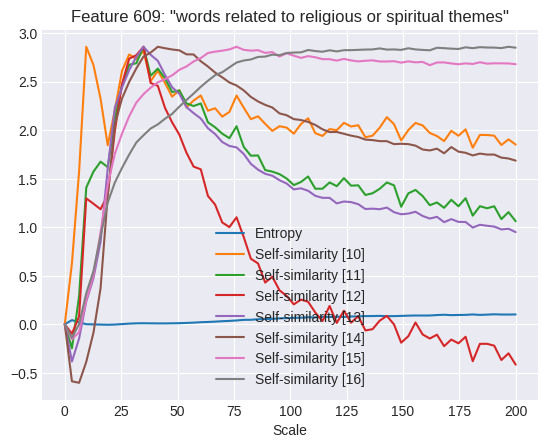

[(0.0,
  'that which is". It is often used to refer to something that is not explicitly stated'),
 (6.451612903225806,
  'thanks". It is often used as a closing phrase on a letter or email, or'),
 (12.903225806451612,
  'there", "that". It is used to indicate a location or a specific quantity.'),
 (19.354838709677416,
  'above, beyond, or the upper part of something." It is often used to refer'),
 (25.806451612903224,
  'Heaven", a place of spiritual or religious significance. It is often used as a refuge'),
 (32.25806451612903,
  'Heaven", a place believed to be the abode of the gods.<eos><eos>The word'),
 (38.70967741935483,
  'above, beyond, or the realm of, the divine or something supreme". It often'),
 (45.16129032258064,
  ' realms beyond the skies, a celestial being, or place." \n\nIt\'s'),
 (51.61290322580645,
  ' realms beyond the natural world, or the infinite and perfect realm of God".\n\nIn'),
 (58.064516129032256,
  ' realms of a heavenly nature, a sphere of infinite size, or a place of absolute'),
 (64.51612903225806,
  ' realms of the heavens or a divine being". It is used to denote a supreme or'),
 (70.96774193548387,
  ' hallowed, divine, or sacred place, and especially, a place of worship".<eos>'),
 (77.41935483870967,
  'a place, region, or position where something is located". \n\nIt is often'),
 (83.87096774193547,
  '<bos>\n\n* A covering, surrounding, or group of something.\n* An idea'),
 (90.32258064516128,
  '<bos> in a state or condition of being absent, lost, or not present".<eos>'),
 (96.77419354838709,
  '<bos>\n\n* A large space, a body of water, or a space that is'),
 (103.2258064516129,
  '<bos>\n\n1. A place, region, or district.\n2. An abstract'),
 (109.6774193548387,
  '<bos>\n\n1. a planet or moon of the Solar System.\n2. a'),
 (116.12903225806451,
  '<bos>\n\n1. A noun that indicates a person, place, thing, or idea'),
 (122.58064516129032,
  '<bos>\n\n1. A part of a sentence, especially one that is used to introduce'),
 (129.03225806451613,
  '<bos>. something that is or is considered to be the whole or extent of something else'),
 (135.48387096774192,
  '<bos>1. A thing, person, or place of a particular kind or category;'),
 (141.93548387096774,
  'a thing, person, or place that is separate and distinct from something else, and'),
 (148.38709677419354,
  'a thing, place or number that is mentioned as a general indication or definition". It'),
 (154.83870967741933,
  'a one or more things that make up a larger thing." It is often used to'),
 (161.29032258064515,
  'CLUDING," "EXCEPT," "ALSO," or "FURTHER."\n\nIt can also be'),
 (167.74193548387095,
  'CLUDING". It is used to indicate that something is not included or is excluded.\n\n'),
 (174.19354838709677,
  'CLUDING, or the state of being, being, or belonging to that group".\n\n'),
 (180.64516129032256,
  'CLUDING". It is most often used to mean that something is not included in a list'),
 (187.09677419354838,
  'CLUDING a specific item or part". It is often used to indicate a lacking or absence'),
 (193.54838709677418,
  'CLUDING". It is a conjunction used to exclude something from a list or set. For'),
 (200.0,
  'CLUDING or including". For example:\n\n* The sun rises in the east and sets')]

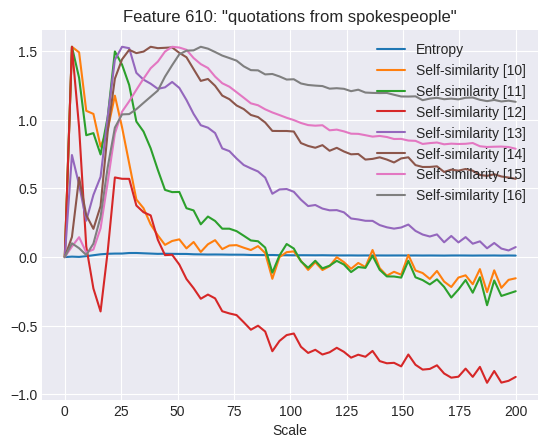

KeyboardInterrupt: 

In [29]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8-darkgrid")
random.seed(9)
for i, e in list(index_explanations.items())[300:]:
    scales, entropy, selfsims, crossents = pick_scale(w_dec[i])
    plt.plot(scales, entropy, label=f"Entropy")
    for l in range(10, PROBE_LAYER + 1):
        plt.plot(scales, selfsims[l] / selfsims[l].max() * selfsims[PROBE_LAYER].max() * 100, label=f"Self-similarity [{l}]")
    for j, c in enumerate(crossents):
        plt.plot(scales, c, label=f"Cross-entropy ({j})")
    plt.title(f"Feature {i}: \"{e}\"")
    plt.xlabel("Scale")
    # plt.ylim(-10, 10)
    plt.legend()
    plt.show()
    selfsim = selfsims[PROBE_LAYER]
    scale_idx = np.argmax(selfsim[1:]) - 1
    highest = selfsim[scale_idx]
    scale = scales[scale_idx]
    scale = scales[scale_idx]
    display(generate_explanations(w_dec[i]))